# Midterm Project: MongoDB Notebooks (Revised)

---

**Student Name:** Andrew McDaniel

**Date:** 06/21/2024

**Course:** DATA 320

**Instructor:** Ted Spence

---
## Table of Contents
1) Introduction
2) Objectives
3) Data Loading
4) Vision Analysis
5) Genre Analysis
6) Sentiment Analysis
7) Statistical Analysis
8) Conclusion
9) Additional Materials

---
## 1) Introduction

The goal of this assignment is to merge an IMDB and Metacritic MongoDB View into a single Pandas DataFrame, and to perform data analysis using the merged data. Charts and plots will be generated to visualize findings, and statistical analysis will be performed.

---
## 2) Objectives
* use YOLO model to determine the number of people in a movie thumbnail
* use HuggingFace to determine the sentiment of a movie based on its description
* use plotly and pyplot to find correlations between number of people in movie thumbnail, sentiment, genre, and gross sales

---
## 3) Data Loading
### Fetch MongoDB Views and merge IMDB and Metacritic View into a Pandas DataFrame

In [191]:
import json
import pymongo
import certifi

In [192]:
# Connect to MongoDB Server
use_mongodb = True
try:
    with open("credentials.json") as f:
        conn = json.load(f)["conn"]
        client = pymongo.MongoClient(conn, tlsCAFile=certifi.where())
        print(f'Using MongoDB version {client.server_info()["version"]}')
except ConnectionError:
    use_mongodb = False
    print('WARNING: Unable to connect to MongoDB Server!')

Using MongoDB version 7.0.11


In [193]:
# Based on Ted Spence's repo: https://github.com/tspence/data-analysis-class-resources/blob/main/jupyter/Basics%20of%20Loading%20Data.ipynb
# Check the databases available on the server
all_databases = client.list_database_names()
print(f'This MongoDB Server has the databases: {all_databases}')

my_database = client['DATA320']
all_collections = my_database.list_collection_names()
print(f'This database has the collections: {all_collections}')

This MongoDB Server has the databases: ['DATA320', 'admin', 'local']
This database has the collections: ['imdb_fixed', 'imbd', 'metacritic', 'imdb_fixed_View']


In [194]:
# define the range of years of movies to analyze
start_year, end_year = 2014, 2019
if end_year < start_year:
    start_year, end_year = end_year, start_year
if start_year == end_year:
    print(f'Analyzing year: {start_year}')
else:
    print(f'Analyzing years: {start_year}-{end_year}')

Analyzing years: 2014-2019


In [195]:
import pandas as pd
import re

In [196]:
# fetch movies from imdb_fixed View
cursor = my_database["imdb_fixed_View"].find({'release_year': {'$gte': start_year, '$lte': end_year}})
imdb = pd.DataFrame(cursor)
imdb.head(4)

,_id,budget,cast,company,director,genres,gross_sales,id,opening_weekend,producer,...,votes,is_gross_sales_usd,is_budget_usd,is_opening_weekend_usd,certification,mpaa,genre,release_year,release_month,release_day
0,637fc91fa23f8f7c1aca9908,NaN,"Rasim Öztekin, Müfit Can Saçinti, Ayda Aksel, ...",MinT Motion Pictures,Müfit Can Saçinti,[Comedy],NaN,3655374,NaN,Birol Güven,...,4503,False,False,False,None,None,{},2014,4,4
1,637fcaeca23f8f7c1aca99b3,165000000.0,"Ellen Burstyn, Matthew McConaughey, Mackenzie ...","Paramount Pictures, Warner Bros., Legendary En...",Christopher Nolan,"[Adventure, Drama, Sci-Fi]",675020017.0,816692,47510360.0,"Kaari Autry, Jenny Basen, Jill Christensen, St...",...,1810697,True,True,True,"[TV-14::(TV rating), PG-13, TV-PG::(recommende...",PG-13,{},2014,10,26
2,637fcb1aa23f8f7c1aca99c2,85000000.0,"Shailene Woodley, Theo James, Ashley Judd, Jai...","Summit Entertainment, Red Wagon Entertainment",Neil Burger,"[Action, Adventure, Mystery, Sci-Fi]",288885818.0,1840309,54607747.0,"Lucy Fisher, John J. Kelly, Michael Paseornek,...",...,461240,True,True,True,[PG-13],PG-13,{},2014,3,18
3,637fcaf6a23f8f7c1aca99b6,170000000.0,"Chris Pratt, Zoe Saldana, Dave Bautista, Vin D...","Marvel Studios, Walt Disney Pictures, Moving P...",James Gunn,"[Action, Adventure, Comedy, Sci-Fi]",774176600.0,2015381,94320883.0,"Victoria Alonso, Jamie Christopher, Louis D'Es...",...,1173531,True,True,True,"[TV-14::(LV), PG-13]",PG-13,{},2014,7,21


In [197]:
# fetch movies from metacritic
metacritic = []
for year in range(start_year, end_year+1):
    cursor = my_database["metacritic"].find({'release_date': re.compile(f"{year}")})
    metacritic.append(pd.DataFrame(cursor))

# cursor = my_database["metacritic"].find({"release_date": re.compile(f"{release_year}")})
metacritic = pd.concat(metacritic, ignore_index=True)
metacritic["score"] = pd.to_numeric(metacritic["score"], errors="coerce")
metacritic["release_date"] = pd.to_datetime(metacritic["release_date"], errors="coerce")
metacritic.head(4)

,_id,movie_id,title,release_date,description,score,thumbnail
0,662a953a95232cf541545607,17816,Ida,2014-05-02,"Poland, 1962. Anna (Agata Trzebuchowska), an e...",91,https://static.metacritic.com/images/products/...
1,662a953a95232cf54154560f,17824,The Grand Budapest Hotel,2014-03-07,The Grand Budapest Hotel recounts the adventur...,88,https://static.metacritic.com/images/products/...
2,662a953a95232cf541545611,17826,Citizenfour,2014-10-24,"In January 2013, filmmaker Laura Poitras was i...",88,https://static.metacritic.com/images/products/...
3,662a953a95232cf541545616,17831,Force Majeure,2014-10-24,A Swedish family travels to the French Alps to...,87,https://static.metacritic.com/images/products/...


In [198]:
# combine imdb and metacritic data into a single pandas dataframe
unified_view = pd.merge(imdb, metacritic, how="inner", on="title")
unified_view.head(4)

,_id_x,budget,cast,company,director,genres,gross_sales,id,opening_weekend,producer,...,genre,release_year,release_month,release_day,_id_y,movie_id,release_date_y,description,score,thumbnail
0,637fcaeca23f8f7c1aca99b3,165000000.0,"Ellen Burstyn, Matthew McConaughey, Mackenzie ...","Paramount Pictures, Warner Bros., Legendary En...",Christopher Nolan,"[Adventure, Drama, Sci-Fi]",675020017.0,816692,47510360.0,"Kaari Autry, Jenny Basen, Jill Christensen, St...",...,{},2014,10,26,662a953a95232cf54154567c,17933,2014-11-05,"With our time on Earth coming to an end, a tea...",74,https://static.metacritic.com/images/products/...
1,637fcb1aa23f8f7c1aca99c2,85000000.0,"Shailene Woodley, Theo James, Ashley Judd, Jai...","Summit Entertainment, Red Wagon Entertainment",Neil Burger,"[Action, Adventure, Mystery, Sci-Fi]",288885818.0,1840309,54607747.0,"Lucy Fisher, John J. Kelly, Michael Paseornek,...",...,{},2014,3,18,662a953b95232cf5415457c4,18261,2014-03-21,In a world where people are divided into disti...,48,https://static.metacritic.com/images/products/...
2,637fcaf6a23f8f7c1aca99b6,170000000.0,"Chris Pratt, Zoe Saldana, Dave Bautista, Vin D...","Marvel Studios, Walt Disney Pictures, Moving P...",James Gunn,"[Action, Adventure, Comedy, Sci-Fi]",774176600.0,2015381,94320883.0,"Victoria Alonso, Jamie Christopher, Louis D'Es...",...,{},2014,7,21,662a953a95232cf541545659,17898,2014-08-01,Brash adventurer Peter Quill finds himself the...,76,https://static.metacritic.com/images/products/...
3,637fcb00a23f8f7c1aca99b9,61000000.0,"Ben Affleck, Rosamund Pike, Neil Patrick Harri...","Twentieth Century Fox, New Regency Productions...",David Fincher,"[Drama, Mystery, Thriller]",369330363.0,2267998,37513109.0,"Ceán Chaffin, Jim Davidson, Leslie Dixon, Josh...",...,{},2014,9,26,662a953a95232cf541545642,17875,2014-10-03,On the occasion of his fifth wedding anniversa...,79,https://static.metacritic.com/images/products/...


In [131]:
# export the unified_view to a csv so the notebook can be run without mongodb
# unified_view.to_csv('unified_view.csv', index=False)

In [132]:
# load the unified_view from a csv to a dataframe, start and end year are fixed at 2014, 2020
# unified_view = pd.read_csv('unified_view.csv')
# start_year = 2014
# end_year = 2020

In [199]:
# ensure the start and end year movies are included
print(f'start_year = {start_year}, end_year = {end_year}\n')
print(unified_view["release_year"][:4], unified_view["release_year"][-5:])

start_year = 2014, end_year = 2019

0    2014
1    2014
2    2014
3    2014
Name: release_year, dtype: int64 2851    2019
2852    2019
2853    2019
2854    2019
2855    2019
Name: release_year, dtype: int64


---
## 4) Vision Analysis
### Use the YOLOv8x Model to Count the Number of People in a Movie Thumbnail

In [200]:
from ultralytics import YOLO

In [201]:
# Load a pretrained YOLO model (recommended for training)
# model = YOLO("yolov8n.pt")  # use this instead to load smaller YOLO8 model
model = YOLO("yolov8x.pt")

# Ultralytics YOLO quickstart reference: https://docs.ultralytics.com/quickstart/#use-ultralytics-with-python
# additional documentation on YOLOv8 and available models here: https://github.com/ultralytics/ultralytics

In [202]:
# find the int associated with people (it's 0)
print(model.names)

{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw

In [203]:
import io
import random
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import requests

In [204]:
# this ensures that matplotlib displays images properly in a notebook
%matplotlib inline

In [205]:
# Converts thumbnail url to a numpy array
def url2img(url):
    response = requests.get(url)
    pil_image = Image.open(io.BytesIO(response.content))
    return np.array(pil_image, dtype=np.uint8)

# Counts people in a YOLO result:
def get_num_people(yolo_result):
    total_person_count = [int(l.cls) for l in yolo_result.boxes].count(0)  # get the class id of each detection, and then count the 0's (the id for people)
    return total_person_count

# Counts the people in a thumbnail, so it can be passed to Pandas to create a new column in the DataFrame
def count_people_in_thumbnail_url(url, verbose=False, yolo_model=YOLO("yolov8x.pt")):
    output = yolo_model([url], verbose=verbose)[0]  # indexing 0 because we are only passing 1 url
    p_count = get_num_people(output)
    return p_count

Manually Selected Thumbnails


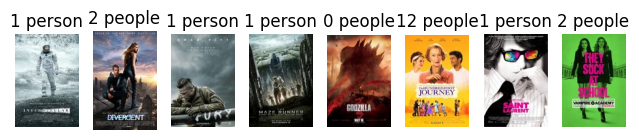

* ================================================== *
Randomly Selected Thumbnails


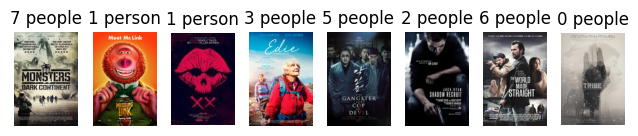

In [232]:
def test_thumbnail_urls(list_of_df_indices):
    thumbnail_urls = [unified_view["thumbnail"][idx] for idx in list_of_df_indices]
    fig, axes = plt.subplots(1, len(thumbnail_urls))
    i = 0
    for thumbnail_url in thumbnail_urls:
        thumbnail = url2img(thumbnail_url)
        person_count = count_people_in_thumbnail_url(thumbnail_url)
        
        tgt_noun = 'person' if person_count == 1 else 'people'
        axes[i].set_title(f'{person_count} {tgt_noun}')
        axes[i].imshow(thumbnail)
        axes[i].axis('off')
        i += 1

    plt.tight_layout()
    plt.show()
    plt.close()

print("Manually Selected Thumbnails")
test_thumbnail_urls([0, 1, 5, 10, 42, 54, 100, 81])  # manually selected to compare between changes

print("*", "="*50, "*")
print("Randomly Selected Thumbnails")
random_urls = random.sample(range(unified_view.shape[0]), 8)
test_thumbnail_urls(random_urls)

### Model Test Results

The model in general performs well, but struggles with thumbnails with cartoon and humanoid characters (such as TMNT). Close portraits, or large groups of people are also not consistently labelled. This model will detect people who are only partially in frame, so thumbnails may have 2 people counted when there is only 1.


### Adding the Person Counts to the Pandas DataFrame
### The following code block will count the number of people in each thumbnail in the dataset - it will take a while to run
### WARNING: This has model has caused my computer to crash! (likely a BIOS issue on my machine, but still run with caution)

In [233]:
# add the "person_count_in_thumbnail" column to the DataFrame
unified_view["person_count_in_thumbnail"] = unified_view["thumbnail"].apply(count_people_in_thumbnail_url)

In [142]:
# let's view the counts to ensure there is some variation in the data
unified_view[unified_view["person_count_in_thumbnail"] > 0]["person_count_in_thumbnail"].head(25)

0     1
1     2
2     2
3     1
4     3
5     1
7     1
8     2
9     1
10    1
11    1
12    5
13    1
14    1
15    1
17    1
18    1
19    4
20    3
21    2
22    6
24    1
25    1
26    2
27    4
Name: person_count_in_thumbnail, dtype: int64

### Plotting & Visualizations

In [218]:
# We're only going to consider movies with gross sales in USD
usd_unified_view = unified_view[unified_view["is_gross_sales_usd"]]
years_string = f'{start_year}' if start_year == end_year else f'{start_year}-{end_year}'
print(usd_unified_view.columns)

Index(['_id_x', 'budget', 'cast', 'company', 'director', 'genres',
       'gross_sales', 'id', 'opening_weekend', 'producer', 'release_date_x',
       'runtime', 'title', 'user_rating', 'votes', 'is_gross_sales_usd',
       'is_budget_usd', 'is_opening_weekend_usd', 'certification', 'mpaa',
       'genre', 'release_year', 'release_month', 'release_day', '_id_y',
       'movie_id', 'release_date_y', 'description', 'score', 'thumbnail',
       'person_count_in_thumbnail'],
      dtype='object')


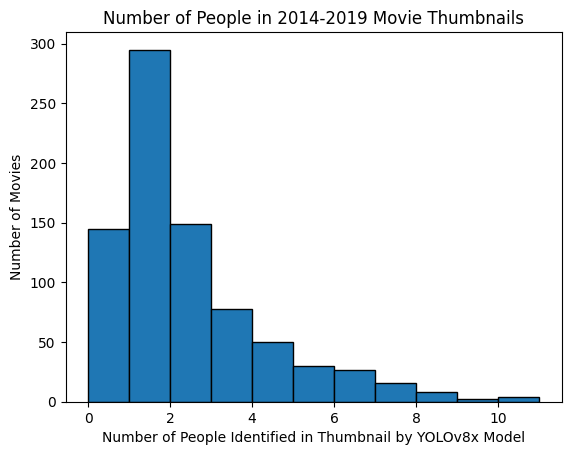

In [219]:
plt.hist(usd_unified_view["person_count_in_thumbnail"], edgecolor="black", bins=range(usd_unified_view["person_count_in_thumbnail"].max()))
plt.title(f"Number of People in {years_string} Movie Thumbnails")
plt.xlabel("Number of People Identified in Thumbnail by YOLOv8x Model")
plt.ylabel("Number of Movies")
plt.show()
plt.close()

### Plot Analysis:
* Most movies thumbnails have 1 person in their thumbnails, it is uncommon for a thumbnail to have more than 3 people in its thumbnail

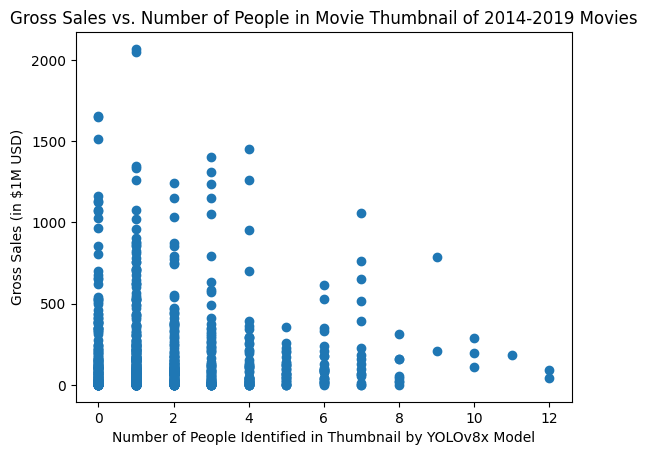

In [145]:
# let's plot the number of people in the thumbnail against the gross sales
plt.scatter(usd_unified_view["person_count_in_thumbnail"], usd_unified_view["gross_sales"] / 1_000_000)
plt.title(f"Gross Sales vs. Number of People in Movie Thumbnail of {years_string} Movies")
plt.xlabel("Number of People Identified in Thumbnail by YOLOv8x Model")
plt.ylabel("Gross Sales (in $1M USD)")
plt.show()
plt.close()

### Plot Analysis:
* There is not a clear correlation between the number of people in the thumbnail and gross sales
* Analyzing average gross sales against average gross sales to see if a trend emerges

In [146]:
# perhaps analyzing the average gross sales for each count of people in the thumbnail will show a better correlation
average_gross_sales_by_num_people_in_thumbnail = usd_unified_view.groupby("person_count_in_thumbnail")["gross_sales"].mean().to_frame()  # Each index will correspond to the number of people in the thumbnail
average_gross_sales_by_num_people_in_thumbnail["person_count_in_thumbnail"] = average_gross_sales_by_num_people_in_thumbnail.index
print(average_gross_sales_by_num_people_in_thumbnail)

                            gross_sales  person_count_in_thumbnail
person_count_in_thumbnail                                         
0                          2.502359e+08                          0
1                          1.858229e+08                          1
2                          1.707013e+08                          2
3                          2.094479e+08                          3
4                          1.863681e+08                          4
5                          9.686051e+07                          5
6                          1.376870e+08                          6
7                          2.745601e+08                          7
8                          9.655999e+07                          8
9                          4.956097e+08                          9
10                         1.964826e+08                         10
11                         1.839361e+08                         11
12                         6.568407e+07                       

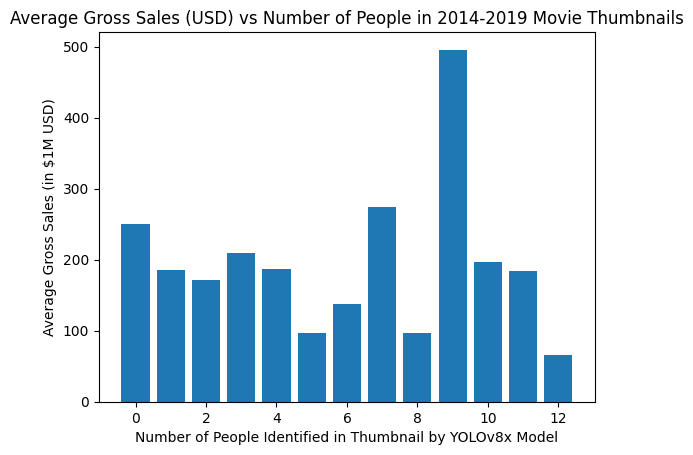

In [147]:
plt.bar(average_gross_sales_by_num_people_in_thumbnail["person_count_in_thumbnail"], average_gross_sales_by_num_people_in_thumbnail["gross_sales"] / 1_000_000)
plt.title(f"Average Gross Sales (USD) vs Number of People in {years_string} Movie Thumbnails")
plt.xlabel("Number of People Identified in Thumbnail by YOLOv8x Model")
plt.ylabel("Average Gross Sales (in $1M USD)")
plt.show()
plt.close()

### Plot Analysis:
* There is not a clear correlation between the number of people in the thumbnail and the average gross sales

---
## 5) Genre Analysis
### Determine if Certain Genres of Movies have More or Less People in their Movie Thumbnails

### Problem: Each movie can have multiple genre, so which genre should be used?
### Solution: Create a new Dataframe that holds duplicate rows that contain an instance for each genre that a movie has been assigned

In [220]:
unified_view_genre_split = unified_view.copy().dropna(subset=["person_count_in_thumbnail", "genres", "mpaa"])
unified_view_genre_split = unified_view_genre_split[unified_view_genre_split["is_gross_sales_usd"]]  # eliminate movies that are not in USD to clean data
new_rows = []
for _, row in unified_view_genre_split.iterrows():
    for genre in row["genres"]:
        new_row = row.copy()
        new_row["genre"] = genre
        new_rows.append(new_row)
        
unified_view_genre_split = pd.DataFrame(new_rows)
unified_view_genre_split[['title', 'genre', 'genres', 'gross_sales', 'person_count_in_thumbnail', 'mpaa']]

,title,genre,genres,gross_sales,person_count_in_thumbnail,mpaa
0,Interstellar,Adventure,"[Adventure, Drama, Sci-Fi]",675020017.0,1,PG-13
0,Interstellar,Drama,"[Adventure, Drama, Sci-Fi]",675020017.0,1,PG-13
0,Interstellar,Sci-Fi,"[Adventure, Drama, Sci-Fi]",675020017.0,1,PG-13
1,Divergent,Action,"[Action, Adventure, Mystery, Sci-Fi]",288885818.0,2,PG-13
1,Divergent,Adventure,"[Action, Adventure, Mystery, Sci-Fi]",288885818.0,2,PG-13
...,...,...,...,...,...,...
2780,Wonder Park,Family,"[Animation, Adventure, Comedy, Drama, Family, ...",119045065.0,1,PG
2780,Wonder Park,Fantasy,"[Animation, Adventure, Comedy, Drama, Family, ...",119045065.0,1,PG
2788,The Sun Is Also a Star,Drama,"[Drama, Music, Romance]",6550029.0,2,PG-13
2788,The Sun Is Also a Star,Music,"[Drama, Music, Romance]",6550029.0,2,PG-13


In [221]:
# perhaps analyzing the average gross sales for each sentiment category will show a better correlation
average_people_by_genre = unified_view_genre_split.groupby("genre")["person_count_in_thumbnail"].agg(['mean', 'std']).reset_index()  # .mean().to_frame()  # Each index will correspond to the number of people in the thumbnail
# average_gross_sales_by_sentiment["person_count_in_thumbnail"] = average_gross_sales_by_sentiment.index
print(average_people_by_genre)

          genre      mean       std
0        Action  1.854962  1.777346
1     Adventure  1.659836  1.837836
2     Animation  0.942857  1.371403
3     Biography  2.020619  1.600647
4        Comedy  2.642857  2.395807
5         Crime  2.022901  1.982483
6   Documentary  0.947368  0.970320
7         Drama  2.050378  1.936487
8        Family  1.392857  1.694491
9       Fantasy  1.600000  1.653580
10      History  1.928571  1.766940
11       Horror  1.107527  1.228841
12        Music  2.642857  2.541715
13      Musical  1.608696  1.587998
14      Mystery  1.413462  1.598607
15      Romance  2.570175  1.986545
16       Sci-Fi  1.586207  1.648173
17        Sport  1.750000  1.773341
18     Thriller  1.502008  1.428750
19          War  2.054054  1.715063
20      Western  2.900000  2.233582


<Figure size 640x480 with 0 Axes>

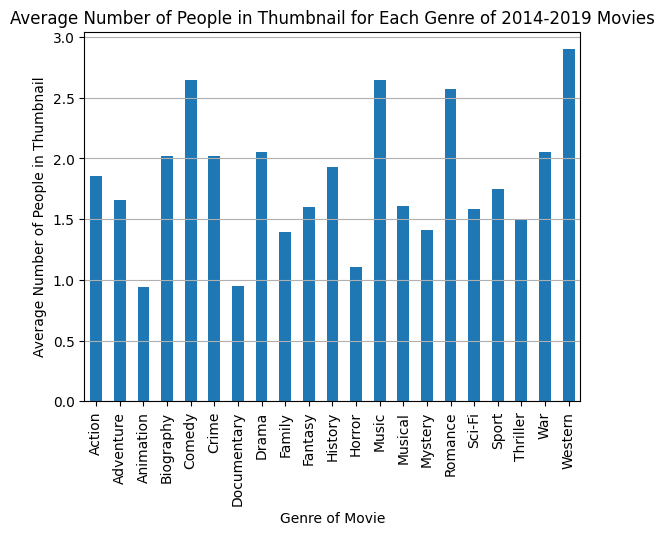

In [222]:
plt.figure()
average_people_by_genre.set_index('genre')[['mean']].plot(kind='bar', legend=False)
plt.title(f"Average Number of People in Thumbnail for Each Genre of {years_string} Movies")
plt.xlabel("Genre of Movie")
plt.ylabel("Average Number of People in Thumbnail")
plt.grid(axis='y')
plt.show()
plt.close()

---
## 6) Sentiment Analysis
### Use the cardiffnlp/twitter-roberta-base-sentiment-latest Model to Determine Sentiment of the Movie Based on it's Description

In [151]:
from transformers import pipeline

In [152]:
# let's test out the sentiment analysis model
model_path = "cardiffnlp/twitter-roberta-base-sentiment-latest"
sentiment_task = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)
print(f'\n{sentiment_task("Covid cases are increasing fast!")},\n '
      f'{sentiment_task("I went to the supermarket.")},\n '
      f'{sentiment_task("I am so happy it is sunny!")}')

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



[{'label': 'negative', 'score': 0.7235766649246216}],
 [{'label': 'neutral', 'score': 0.8198254108428955}],
 [{'label': 'positive', 'score': 0.9873496890068054}]


In [153]:
# define a model to convert negative/neutral/positive to a single numerical score
def class_scores_to_numeric(class_score):
    if class_score[0]['label'] == 'negative':
        return -1*class_score[0]['score'] - 0.5  # range -1.5 to -0.5
    elif class_score[0]['label'] == 'neutral':
        return class_score[0]['score'] - 0.5  # range of -0.5 to 0.5
    elif class_score[0]['label'] == 'positive':
        return class_score[0]['score'] + 0.5  # range of 0.5 to 1.5

# now let's test the new scoring system
print(f'\n{class_scores_to_numeric(sentiment_task("Covid cases are increasing fast!"))},\n '
      f'{class_scores_to_numeric(sentiment_task("I went to the supermarket."))},\n '
      f'{class_scores_to_numeric(sentiment_task("I am so happy it is sunny!"))}')


-1.2235766649246216,
 0.3198254108428955,
 1.4873496890068054


In [154]:
# define a function that determines sentiment based on description, so it can be passed to Pandas to create a new column in the DataFrame
def description_to_sentiment_score(desc):
    sentiment_score =  class_scores_to_numeric(sentiment_task(str(desc)))
    print(f'Sentiment Score: {sentiment_score}')
    return sentiment_score

def description_to_sentiment_category(desc):
    sentiment_category =  sentiment_task(str(desc))[0]['label']
    print(f'Sentiment Category: {sentiment_category}')
    return sentiment_category

In [155]:
usd_unified_view.loc[:, "sentiment_score"] = usd_unified_view["description"].apply(description_to_sentiment_score)

Sentiment Score: 0.27597320079803467
Sentiment Score: -1.1366764307022095
Sentiment Score: 0.10109817981719971
Sentiment Score: -1.2387081980705261
Sentiment Score: 0.34093397855758667
Sentiment Score: 0.17948848009109497
Sentiment Score: 0.062454164028167725
Sentiment Score: 0.2433100938796997
Sentiment Score: 0.16544800996780396
Sentiment Score: 0.2863336205482483
Sentiment Score: 0.08402538299560547
Sentiment Score: 0.19325608015060425
Sentiment Score: 1.4055941104888916
Sentiment Score: 0.2920103669166565
Sentiment Score: 0.32101672887802124
Sentiment Score: 0.22057300806045532
Sentiment Score: 0.12102299928665161
Sentiment Score: 0.2527220845222473
Sentiment Score: -1.2420931458473206
Sentiment Score: 0.2518598437309265
Sentiment Score: 0.19955682754516602
Sentiment Score: 0.2851223945617676
Sentiment Score: 1.242049753665924
Sentiment Score: 0.289017915725708
Sentiment Score: 0.23294413089752197
Sentiment Score: 0.35265636444091797
Sentiment Score: 0.09189069271087646
Sentiment S

C:\Users\andre\AppData\Local\Temp\ipykernel_25708\1726572998.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usd_unified_view.loc[:, "sentiment_score"] = usd_unified_view["description"].apply(description_to_sentiment_score)


In [156]:
usd_unified_view.loc[:, "sentiment_category"] = usd_unified_view["description"].apply(description_to_sentiment_category)

Sentiment Category: neutral
Sentiment Category: negative
Sentiment Category: neutral
Sentiment Category: negative
Sentiment Category: neutral
Sentiment Category: neutral
Sentiment Category: neutral
Sentiment Category: neutral
Sentiment Category: neutral
Sentiment Category: neutral
Sentiment Category: neutral
Sentiment Category: neutral
Sentiment Category: positive
Sentiment Category: neutral
Sentiment Category: neutral
Sentiment Category: neutral
Sentiment Category: neutral
Sentiment Category: neutral
Sentiment Category: negative
Sentiment Category: neutral
Sentiment Category: neutral
Sentiment Category: neutral
Sentiment Category: positive
Sentiment Category: neutral
Sentiment Category: neutral
Sentiment Category: neutral
Sentiment Category: neutral
Sentiment Category: neutral
Sentiment Category: neutral
Sentiment Category: negative
Sentiment Category: neutral
Sentiment Category: neutral
Sentiment Category: neutral
Sentiment Category: positive
Sentiment Category: positive
Sentiment Ca

C:\Users\andre\AppData\Local\Temp\ipykernel_25708\1396350437.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usd_unified_view.loc[:, "sentiment_category"] = usd_unified_view["description"].apply(description_to_sentiment_category)


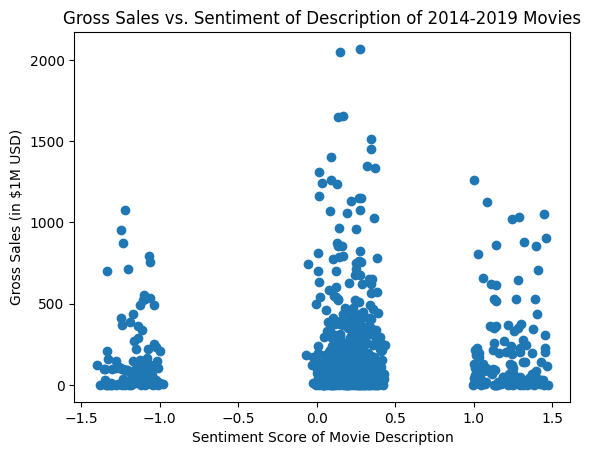

In [157]:
# let's plot the sentiment against the gross sales
plt.scatter(usd_unified_view["sentiment_score"], usd_unified_view["gross_sales"] / 1_000_000)
plt.title(f"Gross Sales vs. Sentiment of Description of {years_string} Movies")
plt.xlabel("Sentiment Score of Movie Description")
plt.ylabel("Gross Sales (in $1M USD)")
plt.show()
plt.close()

### Plot Analysis:
* there is not a clear correlation between movies with a positive sentiment in their descriptions tend to have fewer people in their movie thumbnails
* neutral movie descriptions seem to be more clustered at lower gross sales, analyzing average gross sales for each sentiment category to verify

In [158]:
# perhaps analyzing the average gross sales for each sentiment category will show a better correlation
average_gross_sales_by_sentiment = usd_unified_view.groupby("sentiment_category")["gross_sales"].agg(['mean', 'std']).reset_index()  # .mean().to_frame()  # Each index will correspond to the number of people in the thumbnail
# average_gross_sales_by_sentiment["person_count_in_thumbnail"] = average_gross_sales_by_sentiment.index
average_gross_sales_by_sentiment[['mean', 'std']] = average_gross_sales_by_sentiment[['mean', 'std']] / 1_000_000
print(average_gross_sales_by_sentiment)

  sentiment_category        mean         std
0           negative  144.764323  217.851430
1            neutral  202.120093  301.543439
2           positive  203.261875  276.579902


<Figure size 640x480 with 0 Axes>

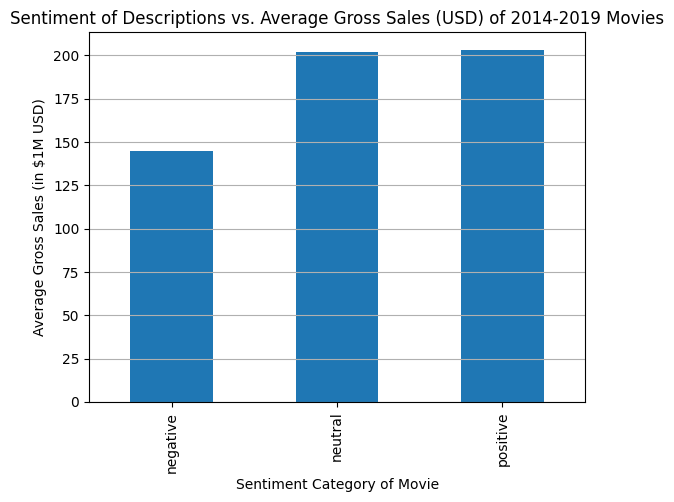

In [159]:
plt.figure()
average_gross_sales_by_sentiment.set_index('sentiment_category')[['mean']].plot(kind='bar', legend=False)
plt.title(f"Sentiment of Descriptions vs. Average Gross Sales (USD) of {years_string} Movies")
plt.xlabel("Sentiment Category of Movie")
plt.ylabel("Average Gross Sales (in $1M USD)")
plt.grid(axis='y')
plt.show()
plt.close()

### Plot Analysis:
* Movies with a positive or negative sentiment in their descriptions tend to have higher gross sales than movies with neutral sentiments in their descriptions On average, this difference is about $75M

In [160]:
# find the average number of people in the thumbnail for each sentiment category
average_and_std_num_of_people_by_sentiment = usd_unified_view.groupby("sentiment_category")["person_count_in_thumbnail"].agg(['mean', 'std']).reset_index()
print(average_and_std_num_of_people_by_sentiment)

  sentiment_category      mean       std
0           negative  1.825397  1.955830
1            neutral  2.042125  1.933780
2           positive  1.888060  2.108559


<Figure size 640x480 with 0 Axes>

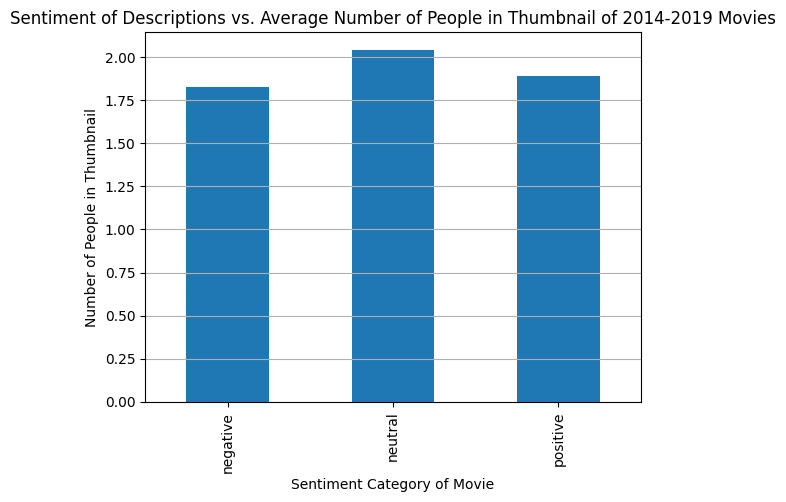

In [161]:
plt.figure()
average_and_std_num_of_people_by_sentiment.set_index('sentiment_category')[['mean']].plot(kind='bar', legend=False)
plt.title(f"Sentiment of Descriptions vs. Average Number of People in Thumbnail of {years_string} Movies")
plt.xlabel("Sentiment Category of Movie")
plt.ylabel("Number of People in Thumbnail")
plt.grid(axis='y')
plt.show()
plt.close()

### Plot Analysis:
* Movies with a positive sentiment in their descriptions tend to have fewer people in their movie thumbnails

---

## 7) Statistical Analysis
### Using the Statsmodels library to perform linear regression to predict gross_sales of movies

In [162]:
import statsmodels.api as sm

In [163]:
ols_df = usd_unified_view.dropna(subset=["budget", "gross_sales"])

X = sm.add_constant(ols_df[["person_count_in_thumbnail", "budget", "sentiment_score", "user_rating"]])

Y = ols_df['gross_sales']

model = sm.OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            gross_sales   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     251.0
Date:                Wed, 26 Jun 2024   Prob (F-statistic):          5.10e-131
Time:                        13:09:12   Log-Likelihood:                -13643.
No. Observations:                 666   AIC:                         2.730e+04
Df Residuals:                     661   BIC:                         2.732e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

### Statistical Analysis Results:
* budget and user_rating was useful for predicting gross sales
* person_count_in_thumbnail and sentiment_score had too large of p values to be reliable 
* Models that use insignificant variables cannot be used reliably for statistical analysis

### Let's remake the model using only significant variables to get a more reliable model

In [164]:
ols_df = usd_unified_view.dropna(subset=["budget", "gross_sales"])

X = sm.add_constant(ols_df[["budget", "user_rating"]])

Y = ols_df['gross_sales']

model = sm.OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            gross_sales   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     499.8
Date:                Wed, 26 Jun 2024   Prob (F-statistic):          4.40e-133
Time:                        13:09:12   Log-Likelihood:                -13644.
No. Observations:                 666   AIC:                         2.729e+04
Df Residuals:                     663   BIC:                         2.731e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -3.295e+08   5.38e+07     -6.124      

### Final OLS Model Analysis
The model cannot be used to reliably predict gross sales from budget and user ratings (r-squared value too low)

---
## 8) Conclusion
Although the OLS model developed cannot be used to predict the gross sales of a movie if the user ratings and budget is known, it is noteworthy that the number of people in a movie thumbnail varies depending on the movie genre. Comedy, Romance, Westerns, and Music genres all have a higher average number of people in their thumbnails based on the results from the YOLO model.


## 9) Additional Materials
* MongoDB Aggregation Pipeline in `mongodb_aggregation_pipeline.txt`
* Conda Environment in `environment.yml`